<a href="https://colab.research.google.com/github/jma02/flow-matching/blob/main/FM_GaussianMixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
pip install flow-matching

In [ ]:
import time
import torch

from torch import nn, Tensor
from sklearn.mixture import GaussianMixture
import numpy as np

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoid meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [ ]:
torch.manual_seed(int(time.time_ns() % (2**32)))

Generating our data. We use Gaussian Mixture Model.

In [ ]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    # Define Gaussian mixture parameters
    means = np.array([[2, 2], [6, 6], [3,5], [10,2]])
    covariances = np.array([[[1, 0], [0, 1]], [[2, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 2]], [[0.5, 0], [0, 0.5]]])
    weights = [0.25, 0.25, 0.25, 0.25]

    gmm = GaussianMixture(n_components=4, weights_init=weights)
    gmm.means_ = means
    gmm.covariances_ = covariances
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances))  # Compute precision matrices
    gmm.weights_ = weights

    samples, _ = gmm.sample(batch_size)  # Generate samples

    data = torch.tensor(samples, dtype=torch.float32, device=device) / 0.45

    return data

Parametrizing our velocity field.

In [ ]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )


    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

Training our velocity field.

In [ ]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 5000
hidden_dim = 512

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr)
losses = []  # Initialize an empty list to store losses
# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad()

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    x_0 = torch.randn_like(x_1).to(device)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device)

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()
    losses.append(loss.item())  # Append the loss to the list

    # optimizer step
    loss.backward() # backward
    optim.step() # update

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()


| iter   5000 | 10.69 ms/step | loss    8.665 
| iter  10000 |  9.01 ms/step | loss    8.597 
| iter  15000 |  8.95 ms/step | loss    8.777 
| iter  20000 |  8.64 ms/step | loss    8.436 


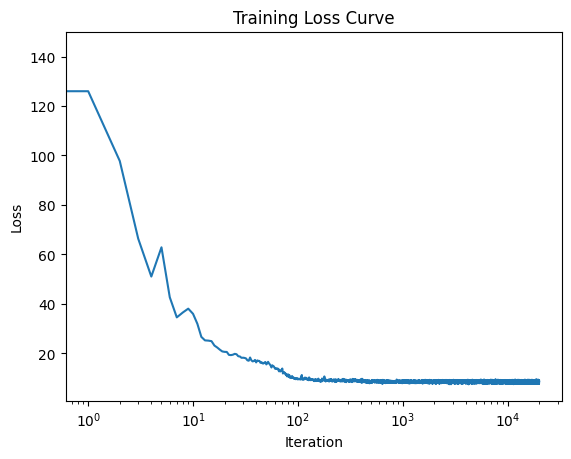

In [ ]:
plt.semilogx(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

Generating samples.

In [ ]:

# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

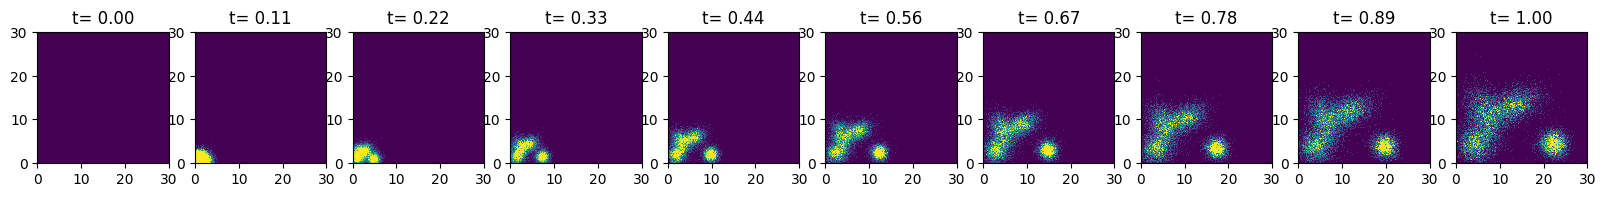

In [ ]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((0,30), (0,30)))

    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((0,30), (0,30)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.show()

Plotting log-likelihood, and comparing with Hutchinson trace estimator.

In [ ]:
from torch.distributions import Independent, Normal

In [ ]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-30, 30, grid_size), torch.linspace(-30, 30, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

In [ ]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

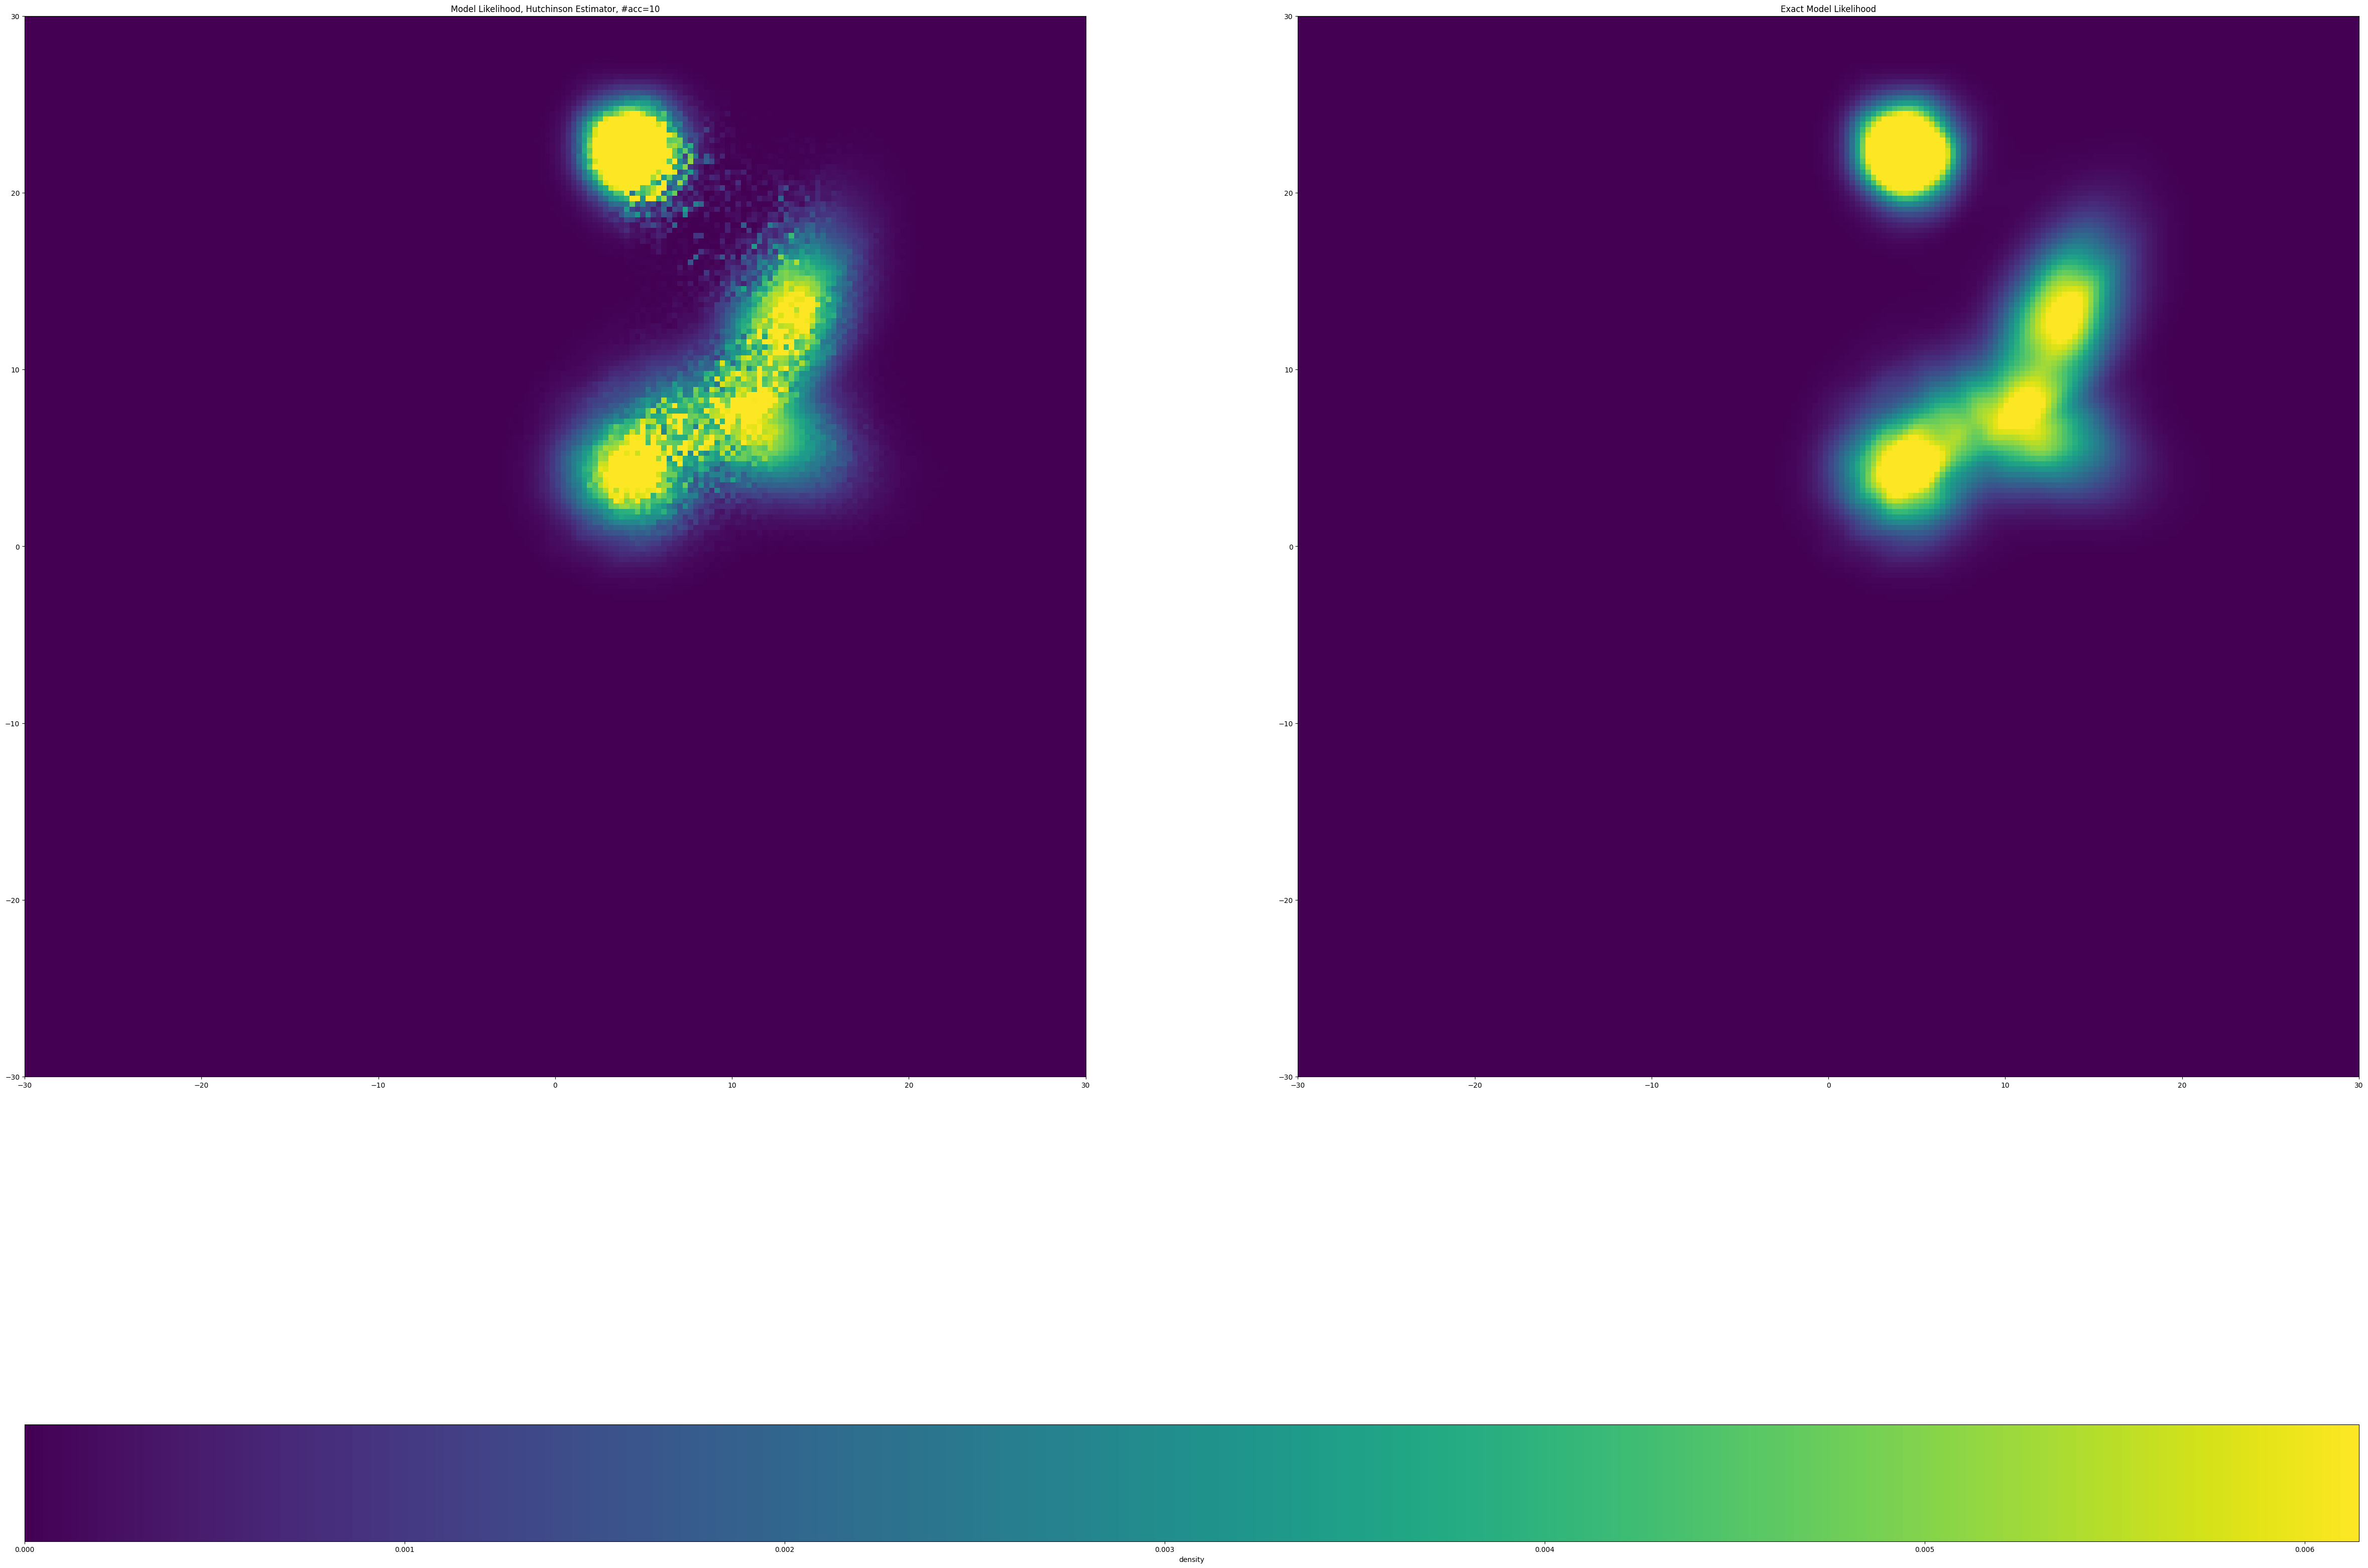

In [ ]:
likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).detach().numpy()

fig, axs = plt.subplots(1, 2,figsize=(60,60))

cmin = 0.0
cmax = torch.quantile(torch.from_numpy(likelihood), 0.99).item()  # Use 99th quantile of likelihood

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood, extent=(-30, 30, -30, 30), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood, extent=(-30, 30, -30, 30), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()

https://openreview.net/pdf?id=fs2Z2z3GRx

In [ ]:
# Generate a sample from the Gaussian Mixture Model
y_true = inf_train_gen(batch_size=1, device=device)

# Add some Gaussian noise
eta = 0.05
noise = torch.randn_like(y_true)*eta
y_0 = y_true + noise

# Set up parameters T, c, K, w, y_0
# According to the paper above, the hyperparameter c and K empirically help govern the balance between unconditional and conditional updates, like the Yang Song paper, and
# the hyperparameter w helps obtain empircally better log-likelihoods of measurement interpolants

# According to the paper, we should tune K, c, and w using a hyperparameter tuner.
w = 1
K = 2
c = 1

T = 50  # sample times

# Sample x_T from 2D Normal Gaussian
x_T = torch.randn((1, 2), dtype=torch.float32, device=device)
Delta_t = 1/T
x_curr = x_T
for i in range(T, 0, -1):
  t = i/T
  t_prev = (i-1)/T
  # We use conditional optimal transport, so alpha_t = (1-t), sigma_t = t
  y_prev = (1-t_prev)*y_0 + w*t_prev*x_T # We don't have any linear operator acting on our data from GMM
  x_prev = x_curr - vf.forward(x_curr, torch.tensor([t], device=device))*Delta_t
  for k in range(1, K+1):
    x_prev = x_prev - (c*(1-t)*Delta_t/t)*(x_prev-y_prev)
  x_curr = x_prev

vals = {
    'x_T: Gaussian noise': x_T,
    'x_curr: Predicted initial unnoised measurement': x_curr,
    'y_true: Unnoised desired data': y_true,
    'y_0: Given noisy measurement': y_0,
}
vals


{'x_T: Gaussian noise': tensor([[-0.1282, -0.6040]], device='cuda:0'),
 'x_curr: Predicted initial unnoised measurement': tensor([[5.6573, 3.7235]], device='cuda:0', grad_fn=<SubBackward0>),
 'y_true: Unnoised desired data': tensor([[5.7183, 3.7370]], device='cuda:0'),
 'y_0: Given noisy measurement': tensor([[5.6576, 3.7237]], device='cuda:0')}

Calculating FID between model generated data and GMM data.

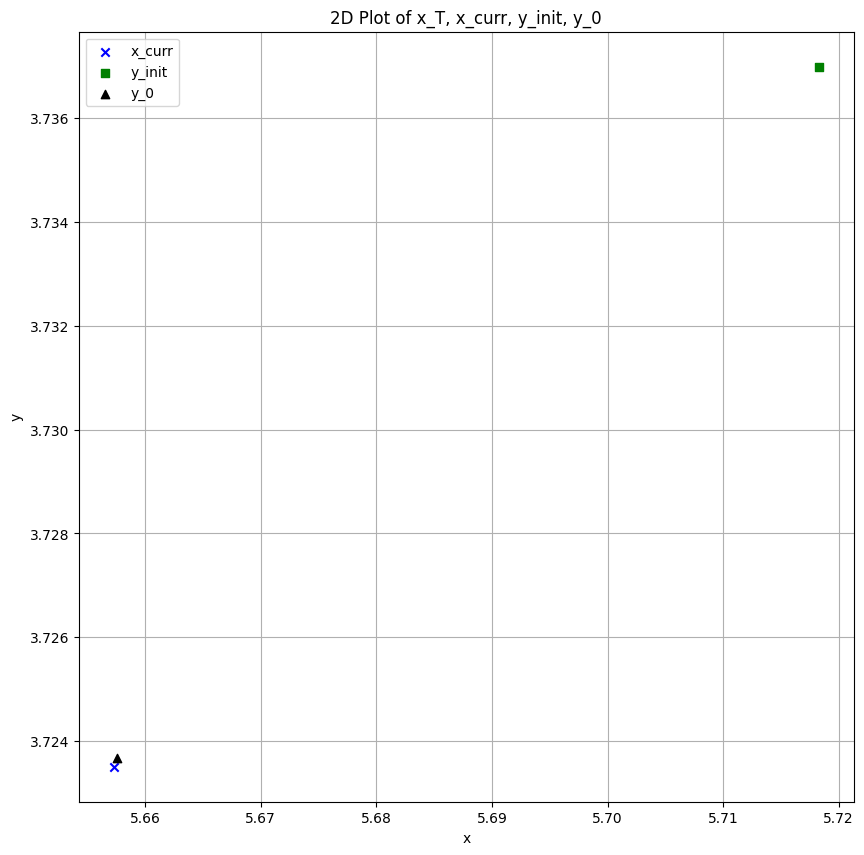

In [ ]:
x_curr = x_curr.cpu().detach().numpy().squeeze()
y_true = y_true.cpu().numpy().squeeze()
y_0 = y_0.cpu().numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.scatter(x_curr[0], x_curr[1], color='blue', marker='x', label='x_curr')
plt.scatter(y_true[0], y_true[1], color='green', marker='s', label='y_init')
plt.scatter(y_0[0], y_0[1], color='black', marker='^', label='y_0')

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Plot of x_T, x_curr, y_init, y_0')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# %%capture
# !pip install pytorch-fid
# !pip install scipy

In [ ]:
# from pytorch_fid import fid_score
# from scipy import linalg
# import os


In [ ]:
# def save_images(samples, path):
#     os.makedirs(path, exist_ok=True)
#     for i, sample in enumerate(samples):
#         plt.figure(figsize=(1, 1))
#         plt.scatter(sample[0], sample[1], s=1)
#         plt.xlim([-10, 10])
#         plt.ylim([-10, 10])
#         plt.axis('off')
#         plt.savefig(os.path.join(path, f'{i}.png'))
#         plt.close()


In [ ]:
# num_samples = 5000

# x_init = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
# solver = ODESolver(velocity_model=wrapped_vf)
# T = torch.tensor([1.]).to(device)
# model_samples = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size)
# model_samples = model_samples.cpu().numpy()


# gmm_samples = inf_train_gen(batch_size=num_samples, device=device)
# gmm_samples = gmm_samples.cpu().numpy()

# save_images(model_samples, 'model_samples')

# save_images(gmm_samples, 'gmm_samples')

In [ ]:
# fid_value = fid_score.calculate_fid_given_paths(['model_samples', 'gmm_samples'],
#                                           batch_size=100,
#                                           device=device,
#                                           dims=2048)
# print(f"FID score: {fid_value}")